# Audience judgements of motion

Consider how participants moved during the concert and how these compare to their ratings of their own and each others (neighbours) movements during music listening.

1. Pull up the motion measurements and segment per piece (remote and hall?)
2. Pull up Questionnaire responses about how they moved
3. Check summary stats on movement behaviour relative to ratings per question
4. Rank motion by participants, can we see what a lot of movement looks like, vs a little?

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d
import pingouin as pg

In [2]:
# NEW NO PD APPEND
def gap_nans(data,gap_t):
    # data is a pandas dataframe with columns called time and/or time_concert which is used to ID gaps greater than gap_T
    # gap_T is in milliseconds (ms)
    # rows of NaN data is added to non-time columns before the first sample, at edges of each gap, and after the last sample of data
    # these nans prevent interpolation errors through missing data
    cols = data.columns
    if 'time' in cols:
        time_col = 'time'
    if 'time_concert' in cols:
        time_col = 'time_concert'
        
    deltat = round(0.35*data[time_col].diff().median())
    dtdeltat =  pd.to_timedelta(deltat,unit = 'ms')
    dt = data[time_col].diff()    
    gapsi = np.array(dt[dt>gap_t].index)
    a = np.append(gapsi-1,dt.index[-1])
    gapsd = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsd[c] = data.loc[a,c]+dtdeltat
        if c.startswith('time'):
            gapsd[c] = data.loc[a,c]+deltat 

    a = np.append(gapsi,dt.index[0])
    gapsp = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsp[c] = data.loc[a,c]-dtdeltat
        if c.startswith('time'):
            gapsp[c] = data.loc[a,c]-deltat 

    data = pd.concat([gapsp,gapsd,data]).sort_values(time_col,ignore_index=True)
    return data

In [3]:
general_loc = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/'

public_mlmotion = general_loc + 'Public/Motion_ML/'
public_ax3 = general_loc +  'Public/Motion_AX3/'
public_Part = general_loc + 'Public/Participants/'
public_time = general_loc + 'Public/Timing/'

In [4]:
general_loc = '../'

public_mlmotion = general_loc + 'Public_data/Motion_ML/'
public_ax3 = general_loc +  'Public_data/Motion_AX3/'
public_Part = general_loc + 'Public_data/Participants/'
public_time = general_loc + 'Public_data/Timing/'

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [5]:
concert_times = pd.read_csv(public_time +'Events_Main.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format

concert_times['sequence'] = concert_times.index
Main_concert_times = concert_times.set_index('Datetime')

In [6]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)

# concert times 10 Hz
ts_ct = np.arange(-1086,9715, 0.1)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')


concert_times = pd.read_csv(public_time +'Events_Full.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format
concert_times['sequence'] = concert_times.index
concert_times.set_index('Datetime',inplace = True)
#concert_times.iloc[50:75]

In [28]:
concert_times = pd.read_csv(public_time +'Events_Main_extra_Tags.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format

concert_times['sequence'] = concert_times.index
Main_concert_times = concert_times.set_index('Datetime')

In [29]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
# need only participants with aligned motion traces and questionnair responses
partDets = partDets.loc[partDets['Questionnaire_Language'].isin(['D','E']),:] # participants with at least some questionnaire responses
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
alignedParts

,Participant_Code,Participant_Number,Attendance,Questionnaire_Language,Motion_Quality,Link_Conflicts,Seat_Zone,Location,Longitude_Truncated,Lattitude_Truncated,Offset_1,Offset_2,Watch_Alone
0,ADQ001,1,A,D,Q,0,6.0,NaN,NaN,NaN,0.14,0.16,0.0
1,ADQ002,2,A,D,Q,0,3.0,NaN,NaN,NaN,NaN,-0.36,0.0
2,ADQ003,3,A,D,Q,0,2.0,NaN,NaN,NaN,0.88,1.02,0.0
3,ADQ004,4,A,D,Q,0,4.0,NaN,NaN,NaN,0.44,0.62,1.0
4,ADQ005,5,A,D,Q,0,4.0,NaN,NaN,NaN,0.04,0.12,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,BEQ115,115,B,E,Q,0,NaN,Porto,41.0,-9.0,-6.32,NaN,1.0
108,BEQ116,116,B,E,Q,0,NaN,Montréal,46.0,-74.0,-30.66,NaN,1.0
109,BEQ117,117,B,E,Q,0,NaN,Stockholm,59.0,17.0,-10.22,NaN,1.0
110,BEQ118,118,B,E,Q,0,NaN,Portola Valley California,37.0,-122.0,-28.00,NaN,0.0


In [27]:
# recalibrated to Events_Main_extra_tags.csv
Event_ranges = {'Beethoven':[6,10],'Schnittke':[15,18],'Bach':[25,26]}
Event_ranges = {'Folk 1':[30,31],'Folk 2':[32,33],'Folk 3':[35,36],'Folk 4':[38,39],'Folk 5':[41,42],'Folk 6':[47,48]}

ev = 'Folk 1'
Main_concert_times.iloc[Event_ranges[ev][0]:Event_ranges[ev][1],:]

,Time_s,Time_ms,Event,Event_Type,Time_Stream,Event_Duration,sequence
Datetime,,,,,,,
2021-10-26 19:28:47,6041.08,6041080,Speech,Speech,7678.32,20.26,30


In [8]:
tic = time.time()
# load those motion traces 
# gather the aligned recordings for the live performance. Combining AX3 and ML data!
aud_df = pd.DataFrame(index = ts_ct)
kept_dev = []
gap_t = 1000

for i,participant in alignedParts.iterrows():
    part = participant['Participant_Code']
    if part[2]=='Q': # Motionlab phone acc
        inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
    else: # AX3
        inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
    inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
    datas = gap_nans(inst_d,1000)
    #get concert time
    resampled = pd.DataFrame(index = ts_ct)
    cols = datas.columns
    for col in cols[1:]:
        f = interpolate.interp1d(datas['time'], datas[col],fill_value='extrapolate')
        resampled[col] = f(ts_ct)
        
    # extract 1D accelerometer feature for easy comparison
    # and basic normalisation
    b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
    
    if part[2]=='R': # aligned AX3 correction factor (basic but verified for low motion conditions)
        aud_df[part] = b.copy()*6 
    else:
        aud_df[part] = b.copy()
#     if np.nanmedian(b)>0:
#         aud_df[part] = b/np.nanmedian(b)
#     else:
#         aud_df[part] = b/np.nanmean(b)
        
aud_df.index = dt_ct
ori_aud_df = aud_df.copy()
ori_aud_df.index = (ts_ct/1000).round(1)

print(time.time()-tic)

87.98109412193298


In [30]:
Near_Rels = pd.read_csv(public_Part + 'Near_Participants_Hall.csv')

# reduce to list of relationships included in the dataset available here
Sub_Rels = Near_Rels.loc[Near_Rels['Participant_Code_1'].isin(aligned_Part_Codes),:]
Sub_Rels = Sub_Rels.loc[Sub_Rels['Participant_Code_2'].isin(aligned_Part_Codes),:].reset_index(drop = True)

In [22]:
aud_df.index = (ts_ct/1000).round(1)
aud_df

,ADQ001,ADQ002,ADQ003,ADQ004,ADQ005,ADQ006,ADQ007,ADQ008,ADQ009,ADQ010,...,BEQ110,BEQ111,BEQ112,BEQ113,BEQ114,BEQ115,BEQ116,BEQ117,BEQ118,BEQ119
-1086.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-1085.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-1085.8,0.740777,0.467856,0.212834,0.101379,0.234912,0.224302,0.486310,0.064859,0.247404,0.237059,...,NaN,0.011573,0.063270,0.032345,NaN,NaN,NaN,NaN,0.227207,NaN
-1085.7,0.691307,0.179505,0.349901,0.100000,0.249657,0.184666,0.597926,0.055355,0.543207,0.371191,...,NaN,0.006860,0.036510,0.010653,NaN,NaN,NaN,NaN,0.183257,NaN
-1085.6,0.711500,0.137325,0.154668,0.063158,0.181522,0.134561,0.456580,0.072090,0.082915,1.156659,...,NaN,0.004449,0.029909,0.017225,NaN,NaN,NaN,NaN,0.140195,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9714.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9714.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9714.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9714.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
Full_Rels = pd.concat([Sub_Rels,Sub_Rels.rename(columns={'Participant_Code_1':'Participant_Code_2','Participant_Code_2':'Participant_Code_1'})])
Full_Rels

,Participant_Code_1,Participant_Code_2,Distance,Familiarity,Relationship
0,ADQ001,ADQ006,3.0,0,Stranger
1,ADQ001,ADQ021,3.0,0,Stranger
2,ADQ001,ADQ023,-2.0,0,Stranger
3,ADQ001,ADQ024,2.0,0,Stranger
4,ADQ001,ADQ031,-2.0,0,Stranger
...,...,...,...,...,...
565,AEQ083,AEQ082,3.0,0,Stranger
566,AEQ087,AEQ082,3.0,0,Stranger
567,AEQ089,AEQ083,3.0,1,Family_ParentChild
568,AER090,AEQ084,3.0,1,Family_ParentChild


## Check out questionnair responses

In [9]:
public_Part

'../Public_data/Participants/'

In [99]:
# pull audience questionnair responses
Quest_df = pd.read_csv(public_Part + 'Surveys_Prepared_Data_Public.csv',sep=',', encoding='latin-1')
Quest_df = Quest_df.loc[Quest_df['ParticipantCode'].isin(aligned_Part_Codes),:].reset_index(drop = True)
Quest_df

,ParticipantCode,age,gender,musician_status,personal_relation,fan,EC_1,EC_2,EC_3,EC_4,...,changed_behaviour,EC,EC_noTouched,AIMS,KM_Beethoven,KM_Schnittke,KM_Folk,AWE_Beethoven,AWE_Schnittke,AWE_Folk
0,AEQ086,NaN,Woman,Music-loving nonmusician,No_Relation,1.0,3.0,2.0,5.0,2.0,...,NaN,4.000000,4.000000,85,1.4,1.1,1.4,4.333333,4.166667,4.333333
1,AEQ088,NaN,Man,Semiprofessional musician,Relative_Friend,6.0,2.0,3.0,4.0,2.0,...,NaN,3.142857,3.166667,108,2.9,4.2,3.2,4.666667,4.833333,4.666667
2,AEQ077,24.0,Woman,Professional musician,No_Relation,5.0,5.0,1.0,4.0,1.0,...,NaN,4.857143,4.833333,159,4.1,3.9,5.0,4.500000,5.666667,6.333333
3,AEQ081,46.0,Man,Music-loving nonmusician,No_Relation,6.0,4.0,4.0,5.0,3.0,...,NaN,3.714286,3.666667,130,2.8,2.9,4.0,5.500000,6.500000,5.000000
4,AEQ079,71.0,Man,Music-loving nonmusician,No_Relation,7.0,5.0,4.0,4.0,2.0,...,NaN,4.285714,4.166667,141,5.2,3.0,2.6,5.000000,6.000000,5.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,BEQ114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,2.6,2.7,NaN,2.500000,3.333333,NaN
108,BEQ095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,133,4.0,0.6,3.0,3.666667,4.000000,3.666667
109,BEQ115,26.0,Woman,Professional musician,No_Relation,4.0,5.0,2.0,5.0,1.0,...,NaN,4.571429,4.666667,0,3.0,NaN,NaN,3.833333,NaN,NaN
110,BDQ092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,1.8,1.6,NaN,4.166667,4.333333,NaN


In [101]:
Quest_text = pd.read_csv(public_Part + 'Surveys_Codebook.csv', delimiter=",", encoding='latin-1')


In [102]:
list1 = Quest_df.columns.values
list2 = Quest_text['ID'].values
s1 = set(list1)
s2 = set(list2)

if s1 == s2:
    print("Both List are the same")
else:
    print("Not same")
    print(s1.difference(s2))
    print(s2.difference(s1))

Both List are the same


In [77]:
df = Quest_df
unique_counts = pd.DataFrame.from_records([(col, df[col].nunique()) for col in df.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])
unique_counts['']

,Column_Name,Num_Unique
198,group,2
197,language,2
4,personal_relation,2
200,viewing_with_others,2
2,gender,3
...,...,...
215,KM_Folk,46
214,KM_Schnittke,48
1,age,51
212,AIMS,67


In [103]:
sub_Q_List=['ParticipantCode',
            'aware_body_Beethoven', 'aware_movement_Beethoven', 'aware_others_moving_Beethoven',
            'aware_body_Schnittke', 'aware_movement_Schnittke', 'aware_others_moving_Schnittke',
            'aware_body_Bach', 'aware_movement_Bach', 'aware_others_moving_Bach', # bach
            'aware_body_Folk', 'aware_movement_Folk', 'aware_others_moving_Folk']

In [104]:
sub_text = Quest_text.loc[Quest_text['ID'].isin(sub_Q_List),:]
sub_text.set_index('ID',drop=True,inplace = True)
sub_text

,English_Q,Danish_Q,Response_Type,Data_Type,Response_Options_English,Response_Options_Danish,Survey_Timing,Survey_Timing_Code,Repeated_Question_Code,Note,Reference
ID,,,,,,,,,,,
ParticipantCode,NaN,NaN,factor,string,NaN,NaN,NaN,NaN,NaN,Participant Identifier. See the README for inf...,NaN
aware_body_Beethoven,Were you aware of your physical body during th...,Var du opmærksom på din krop gennem dette stykke?,multiple choice,string,"""Not at all, Rarely, Intermittently, Continuou...","""Overhovedet ikke, Sjældent, Fra tid til anden...",Post-Beethoven,2.0,38.0,Developed for MusicLab Copenhagen,NaN
aware_movement_Beethoven,Were you aware of your own physical movement d...,Var du opmærksom på dine egne bevægelser genne...,multiple choice,string,"""Not aware of movement, Yes and I moved less t...","""Ikke opmærksom på bevægelse, Ja og jeg bevæge...",Post-Beethoven,2.0,39.0,Developed for MusicLab Copenhagen,NaN
aware_others_moving_Beethoven,Were you aware of others in the audience movin...,Var du opmærksom på at andre i publikum bevæge...,multiple choice,string,"""Not aware of others' movement, Yes and they m...","""Ikke opmærksom på andres bevægelse, Ja og de ...",Post-Beethoven,2.0,40.0,Developed for MusicLab Copenhagen,NaN
aware_body_Schnittke,Were you aware of your physical body during th...,Var du opmærksom på din krop gennem dette stykke?,multiple choice,string,"""Not at all, Rarely, Intermittently, Continuou...","""Overhovedet ikke, Sjældent, Fra tid til anden...",Post-Schnittke,3.0,38.0,Developed for MusicLab Copenhagen,NaN
aware_movement_Schnittke,Were you aware of your own physical movement d...,Var du opmærksom på dine egne bevægelser genne...,multiple choice,string,"""Not aware of movement, Yes and I moved less t...","""Ikke opmærksom på bevægelse, Ja og jeg bevæge...",Post-Schnittke,3.0,39.0,Developed for MusicLab Copenhagen,NaN
aware_others_moving_Schnittke,Were you aware of others in the audience movin...,Var du opmærksom på at andre i publikum bevæge...,multiple choice,string,"""Not aware of others' movement, Yes and they m...","""Ikke opmærksom på andres bevægelse, Ja og de ...",Post-Schnittke,3.0,40.0,Developed for MusicLab Copenhagen,NaN
aware_body_Bach,Were you aware of your physical body during th...,Var du opmærksom på din krop gennem dette stykke?,multiple choice,integer,"""Not at all, Rarely, Intermittently, Continuou...","""Overhovedet ikke, Sjældent, Fra tid til anden...",Post-Bach,4.0,38.0,Developed for MusicLab Copenhagen,NaN
aware_movement_Bach,Were you aware of your own physical movement d...,Var du opmærksom på dine egne bevægelser genne...,multiple choice,integer,"""Not aware of movement, Yes and I moved less t...","""Ikke opmærksom på bevægelse, Ja og jeg bevæge...",Post-Bach,4.0,39.0,Developed for MusicLab Copenhagen,NaN


In [105]:
sub_Q = Quest_df[sub_Q_List].copy()
sub_Q = sub_Q.sort_values('ParticipantCode').reset_index()
sub_Q

,index,ParticipantCode,aware_body_Beethoven,aware_movement_Beethoven,aware_others_moving_Beethoven,aware_body_Schnittke,aware_movement_Schnittke,aware_others_moving_Schnittke,aware_body_Bach,aware_movement_Bach,aware_others_moving_Bach,aware_body_Folk,aware_movement_Folk,aware_others_moving_Folk
0,61,ADQ001,Intermittently,Yes and I moved less than usual,Yes and they moved less than usual,Continuously,Yes and I moved a normal amount,Yes and they moved a normal amount,Intermittently,Yes and I moved less than usual,Not aware of others' movement,Continuously,Yes and I moved more than usual,Yes and they moved more than usual
1,83,ADQ002,Rarely,Not aware of movement,Not aware of others' movement,Not at all,Yes and I moved less than usual,Not aware of others' movement,Intermittently,Not aware of movement,Not aware of others' movement,Intermittently,Yes and I moved more than usual,Yes and they moved more than usual
2,68,ADQ003,Continuously,Yes and I moved a normal amount,Not aware of others' movement,Intermittently,Yes and I moved less than usual,Yes and they moved a normal amount,Intermittently,Yes and I moved a normal amount,Yes and they moved less than usual,Intermittently,Yes and I moved less than usual,Yes and they moved less than usual
3,28,ADQ004,Not at all,Yes and I moved less than usual,Not aware of others' movement,Rarely,Yes and I moved a normal amount,Not aware of others' movement,Not at all,Not aware of movement,Not aware of others' movement,Intermittently,Yes and I moved more than usual,Yes and they moved more than usual
4,55,ADQ005,Intermittently,Yes and I moved less than usual,Yes and they moved a normal amount,Intermittently,Yes and I moved less than usual,Yes and they moved a normal amount,Not at all,Yes and I moved less than usual,Not aware of others' movement,Rarely,Yes and I moved a normal amount,Yes and they moved less than usual
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,109,BEQ115,Intermittently,Yes and I moved a normal amount,Not aware of others' movement,NaN,NaN,NaN,Rarely,Not aware of movement,Not aware of others' movement,NaN,NaN,NaN
108,101,BEQ116,Continuously,Yes and I moved less than usual,Not aware of others' movement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,94,BEQ117,Intermittently,Yes and I moved a normal amount,Not aware of others' movement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,89,BEQ118,Intermittently,Yes and I moved a normal amount,Not aware of others' movement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
sub_H = sub_Q.loc[sub_Q['ParticipantCode'].str.startswith('A'),:].copy()
sub_H

,index,ParticipantCode,aware_body_Beethoven,aware_movement_Beethoven,aware_others_moving_Beethoven,aware_body_Schnittke,aware_movement_Schnittke,aware_others_moving_Schnittke,aware_body_Bach,aware_movement_Bach,aware_others_moving_Bach,aware_body_Folk,aware_movement_Folk,aware_others_moving_Folk
0,61,ADQ001,Intermittently,Yes and I moved less than usual,Yes and they moved less than usual,Continuously,Yes and I moved a normal amount,Yes and they moved a normal amount,Intermittently,Yes and I moved less than usual,Not aware of others' movement,Continuously,Yes and I moved more than usual,Yes and they moved more than usual
1,83,ADQ002,Rarely,Not aware of movement,Not aware of others' movement,Not at all,Yes and I moved less than usual,Not aware of others' movement,Intermittently,Not aware of movement,Not aware of others' movement,Intermittently,Yes and I moved more than usual,Yes and they moved more than usual
2,68,ADQ003,Continuously,Yes and I moved a normal amount,Not aware of others' movement,Intermittently,Yes and I moved less than usual,Yes and they moved a normal amount,Intermittently,Yes and I moved a normal amount,Yes and they moved less than usual,Intermittently,Yes and I moved less than usual,Yes and they moved less than usual
3,28,ADQ004,Not at all,Yes and I moved less than usual,Not aware of others' movement,Rarely,Yes and I moved a normal amount,Not aware of others' movement,Not at all,Not aware of movement,Not aware of others' movement,Intermittently,Yes and I moved more than usual,Yes and they moved more than usual
4,55,ADQ005,Intermittently,Yes and I moved less than usual,Yes and they moved a normal amount,Intermittently,Yes and I moved less than usual,Yes and they moved a normal amount,Not at all,Yes and I moved less than usual,Not aware of others' movement,Rarely,Yes and I moved a normal amount,Yes and they moved less than usual
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,0,AEQ086,Continuously,Yes and I moved less than usual,Yes and they moved less than usual,Continuously,Yes and I moved less than usual,Yes and they moved less than usual,Continuously,Yes and I moved less than usual,Yes and they moved less than usual,Continuously,Yes and I moved less than usual,Yes and they moved a normal amount
81,11,AEQ087,Intermittently,Yes and I moved a normal amount,Not aware of others' movement,Rarely,Yes and I moved less than usual,Not aware of others' movement,Not at all,Not aware of movement,Not aware of others' movement,Intermittently,Yes and I moved a normal amount,Yes and they moved a normal amount
82,1,AEQ088,Intermittently,Yes and I moved a normal amount,Not aware of others' movement,Intermittently,Yes and I moved a normal amount,Not aware of others' movement,Rarely,Not aware of movement,Not aware of others' movement,Rarely,Yes and I moved a normal amount,Not aware of others' movement
83,8,AEQ089,Intermittently,Not aware of movement,Not aware of others' movement,Intermittently,Yes and I moved a normal amount,Yes and they moved a normal amount,Intermittently,Yes and I moved a normal amount,Yes and they moved a normal amount,Intermittently,Yes and I moved a normal amount,Yes and they moved a normal amount


<AxesSubplot:>

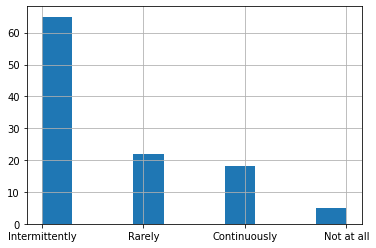

In [108]:
c = 'aware_body_Beethoven'
sub_Q[c].hist()

In [116]:
# reQ
req_Q_List=['ParticipantCode','Music','Stimuli_N','aware_body', 'aware_movement', 'aware_others_moving']
sub_list = ['ParticipantCode','aware_body', 'aware_movement', 'aware_others_moving']
Stimuli_N = {1:'Beethoven',2:'Schnittke',3:'Bach',4:'Folk'}

req_Q = pd.DataFrame(columns = req_Q_List)

for stim in Stimuli_N.keys():
    mtag= Stimuli_N[stim]
    A = sub_Q.loc[:,['ParticipantCode','aware_body_'+mtag, 'aware_movement_'+mtag, 'aware_others_moving_'+mtag]].copy()
    A=A.rename(columns={'aware_body_'+mtag:'aware_body', 'aware_movement_'+mtag:'aware_movement','aware_others_moving_'+mtag:'aware_others_moving'})
    A['Music'] = mtag
    A['Stimuli_N'] = stim

    req_Q = pd.concat([req_Q,A],axis=0)

req_Q

,ParticipantCode,Music,Stimuli_N,aware_body,aware_movement,aware_others_moving
0,ADQ001,Beethoven,1,Intermittently,Yes and I moved less than usual,Yes and they moved less than usual
1,ADQ002,Beethoven,1,Rarely,Not aware of movement,Not aware of others' movement
2,ADQ003,Beethoven,1,Continuously,Yes and I moved a normal amount,Not aware of others' movement
3,ADQ004,Beethoven,1,Not at all,Yes and I moved less than usual,Not aware of others' movement
4,ADQ005,Beethoven,1,Intermittently,Yes and I moved less than usual,Yes and they moved a normal amount
...,...,...,...,...,...,...
107,BEQ115,Folk,4,NaN,NaN,NaN
108,BEQ116,Folk,4,NaN,NaN,NaN
109,BEQ117,Folk,4,NaN,NaN,NaN
110,BEQ118,Folk,4,NaN,NaN,NaN


Add the average motion per segment to the rating information per participant

In [133]:
Cond = ['Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual'] # hall for 85 and virtual for 30

#Event_ranges = {'Beethoven':[8,12],'Schnittke':[17,20],'Bach':[28,29]}
Event_ranges = {'Beethoven':[6,10],'Schnittke':[15,18],'Bach':[25,26]}

mm_df = pd.DataFrame(columns=['Participant','Condition','Music','mQoM'])

for ev in Event_ranges.keys():
    mdf = pd.DataFrame(columns=['Participant','Condition','Music','mQoM','aware_body', 'aware_movement', 'aware_others_moving'])
    mdf['Participant']= aud_df.columns.values
    mdf['Condition'] = Cond
    mdf['Music'] = ev
    mdf['aware_body'] = sub_Q['aware_body_'+ev]
    mdf['aware_movement'] = sub_Q['aware_movement_'+ev]
    mdf['aware_others_moving'] = sub_Q['aware_others_moving_'+ev]

    seg_start = Main_concert_times.iloc[Event_ranges[ev][0],0]
    seg_end = Main_concert_times.iloc[Event_ranges[ev][1],0]
    mdf.loc[:,'mQoM'] = aud_df.loc[seg_start:seg_end,:].copy().mean(skipna=True).values
    motion_seen = []
    motion_seen_max = []
    for part in mdf['Participant']:
        neighbours = Full_Rels.loc[Full_Rels['Participant_Code_1'].isin([part]),:]
        seen_neighbours = neighbours.loc[neighbours['Distance'].isin([1.0,2.0]),'Participant_Code_2'].values
        motion_seen.append(mdf.loc[mdf['Participant'].isin(seen_neighbours),'mQoM'].mean())
        motion_seen_max.append(mdf.loc[mdf['Participant'].isin(seen_neighbours),'mQoM'].max()) # mean()
    mdf['Motion_seen'] = motion_seen
    mdf['Motion_seen_Max'] = motion_seen_max

    mm_df = pd.concat([mm_df,mdf])

# Folk
#Event_ranges = {'Folk 1':[33,34],'Folk 2':[35,36],'Folk 3':[38,39],'Folk 4':[41,42],'Folk 5':[44,45],'Folk 6':[50,51]}
Event_ranges = {'Folk 1':[30,31],'Folk 2':[32,33],'Folk 3':[35,36],'Folk 4':[38,39],'Folk 5':[41,42],'Folk 6':[47,48]}

folk_df = pd.DataFrame(columns = Event_ranges.keys())
for ev in Event_ranges:
    print(ev)
    seg_start = Main_concert_times.iloc[Event_ranges[ev][0],0]
    seg_end = Main_concert_times.iloc[Event_ranges[ev][1],0]
    folk_df.loc[:,ev] = aud_df.loc[seg_start:seg_end,:].copy().mean(skipna=True).values
    
ev = 'Folk'
print(ev)
mdf = pd.DataFrame(columns=['Participant','Condition','Music','mQoM','aware_body', 'aware_movement', 'aware_others_moving'])
mdf['Participant']= aud_df.columns.values
mdf['Condition'] = Cond
mdf['Music'] = ev
mdf['aware_body'] = sub_Q['aware_body_'+ev]
mdf['aware_movement'] = sub_Q['aware_movement_'+ev]
mdf['aware_others_moving'] = sub_Q['aware_others_moving_'+ev]

mdf.loc[:,'mQoM'] = folk_df.mean(axis=1,skipna=True).values
motion_seen = []
motion_seen_max = []
for part in mdf['Participant']:
    neighbours = Full_Rels.loc[Full_Rels['Participant_Code_1'].isin([part]),:]
    seen_neighbours = neighbours.loc[neighbours['Distance'].isin([1.0,2.0]),'Participant_Code_2'].values
    motion_seen.append(mdf.loc[mdf['Participant'].isin(seen_neighbours),'mQoM'].mean())
    motion_seen_max.append(mdf.loc[mdf['Participant'].isin(seen_neighbours),'mQoM'].max()) # mean()
mdf['Motion_seen'] = motion_seen
mdf['Motion_seen_Max'] = motion_seen_max

mm_df = pd.concat([mm_df,mdf])
# what are these stray values?? test with mm_df['aware_body'].hist()
mm_df=mm_df.replace(['0','5'], np.nan)

mm_df

Folk 1
Folk 2
Folk 3
Folk 4
Folk 5
Folk 6
Folk


,Participant,Condition,Music,mQoM,aware_body,aware_movement,aware_others_moving,Motion_seen,Motion_seen_Max
0,ADQ001,Hall,Beethoven,0.069310,Intermittently,Yes and I moved less than usual,Yes and they moved less than usual,0.127867,0.143615
1,ADQ002,Hall,Beethoven,NaN,Rarely,Not aware of movement,Not aware of others' movement,0.085446,0.093232
2,ADQ003,Hall,Beethoven,0.094418,Continuously,Yes and I moved a normal amount,Not aware of others' movement,0.104520,0.132908
3,ADQ004,Hall,Beethoven,0.101832,Not at all,Yes and I moved less than usual,Not aware of others' movement,0.101747,0.107947
4,ADQ005,Hall,Beethoven,0.073396,Intermittently,Yes and I moved less than usual,Yes and they moved a normal amount,0.056471,0.056471
...,...,...,...,...,...,...,...,...,...
107,BEQ115,Virtual,Folk,0.270163,NaN,NaN,NaN,NaN,NaN
108,BEQ116,Virtual,Folk,1.029549,NaN,NaN,NaN,NaN,NaN
109,BEQ117,Virtual,Folk,NaN,NaN,NaN,NaN,NaN,NaN
110,BEQ118,Virtual,Folk,NaN,NaN,NaN,NaN,NaN,NaN


In [251]:
mm_df.to_csv('Participants_Pieces_motion_judgements.csv')

## Plot results of questionnairs and motion
Most of these analyses are only on the motion of the participants in the hall. 


In [134]:
mm_df_Hall = mm_df.loc[mm_df['Condition'].isin(['Hall']),:]
mm_df_Virt = mm_df.loc[mm_df['Condition'].isin(['Virtual']),:]
# less 
mm_df_less = mm_df_Hall.loc[mm_df_Hall['Music'].isin(['Beethoven','Schnittke','Bach']),:]
mm_df_Folk = mm_df_Hall.loc[mm_df_Hall['Music'].isin(['Folk']),:]

### Awareness of participants of their own bodies


In [253]:
tag_Q = 'aware_body'
tag_m = 'mQoM'
QuT = sub_text.loc[tag_Q + '_' + 'Folk','English_Q']
sub_text.loc[sub_text.index.str.startswith(tag_Q),'English_Q']

ID
aware_body_Beethoven    Were you aware of your physical body during th...
aware_body_Schnittke    Were you aware of your physical body during th...
aware_body_Bach         Were you aware of your physical body during th...
aware_body_Folk         Were you aware of your physical body during th...
Name: English_Q, dtype: object

In [254]:
print(QuT)


Were you aware of your physical body during this piece?


In [202]:
mm_df[tag_Q].unique()

array(['Intermittently', 'Rarely', 'Continuously', 'Not at all', nan],
      dtype=object)

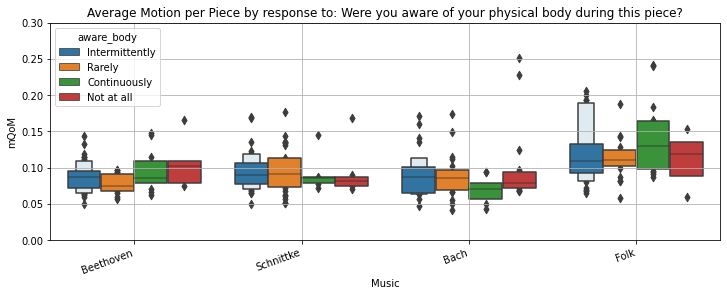

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pingouin/distribution.py:946: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d)**d


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,aware_body,0.001393,2,19,0.000697,0.475852,6.285639e-01,0.047700,NaN
1,Music,0.018624,3,57,0.006208,17.090753,4.896319e-08,0.473549,0.522018
2,Interaction,0.005204,6,57,0.000867,2.387961,3.972554e-02,0.200872,NaN


In [203]:
f, (ax1) = plt.subplots(1, 1,figsize=(12,4))
response_order = ['Continuously','Intermittently','Rarely','Not at all']
sns.boxenplot(x = 'Music',y = tag_m, hue = tag_Q,data = mm_df_Hall, ax = ax1)
plt.xticks(rotation='20',ha = 'right',fontsize=10)
plt.title('Average Motion per Piece by response to: ' + QuT)
plt.ylim([0,0.3])
plt.grid()
#plt.savefig('plots/Musics_mQoM_Hall_Virtual.png',dpi = 400)
plt.show()
pg.mixed_anova(dv=tag_m,within = 'Music',between = tag_Q,subject='Participant',data=mm_df_Hall)


       Source  ddof1      ddof2         F     p-unc       np2
0  aware_body      3  84.545142  0.304361  0.822162  0.003408


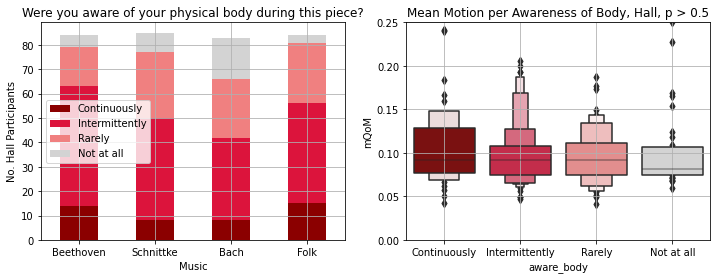

<Figure size 432x288 with 0 Axes>

In [204]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
response_order = ['Continuously','Intermittently','Rarely','Not at all']
my_pal = {'Continuously':'darkred','Intermittently':'crimson','Rarely':'lightcoral','Not at all':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_H[tag_Q + '_' + t].value_counts()

f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

sub_hist_df.plot(kind='bar',stacked=True,color = my_pal.values(),ax = ax1)
ax1.legend(loc="center left")
ax1.grid()
ax1.tick_params(axis='x',labelrotation=0)
ax1.set_title(QuT)
#ax1.set_title('Hall Participants awareness of their own bodies')
ax1.set_ylabel('No. Hall Participants')
ax1.set_xlabel('Music')

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_Hall)
print(aov)

sns.boxenplot(x = tag_Q,y = tag_m, palette=my_pal,order = response_order,data = mm_df_Hall, ax = ax2)
ax2.set_title('Mean Motion per Awareness of Body, Hall, p > 0.5')
ax2.set_ylim([0,0.25])
ax2.grid()

plt.show()
plt.savefig('./Plots/body_aware_A_R_qom.png',dpi = 300)

In [234]:
pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Continuously,Intermittently,0.108426,0.111501,-0.003075,0.007493,-0.410449,121.861825,0.900000,-0.063668
1,Continuously,Not at all,0.108426,0.101341,0.007085,0.010421,0.679867,55.614472,0.900000,0.154406
2,Continuously,Rarely,0.108426,0.104930,0.003496,0.008418,0.415295,141.118372,0.900000,0.069562
3,Intermittently,Not at all,0.111501,0.101341,0.010160,0.009768,1.040153,47.714280,0.704255,0.202917
4,Intermittently,Rarely,0.111501,0.104930,0.006571,0.007594,0.865284,232.202582,0.799843,0.102374
5,Not at all,Rarely,0.101341,0.104930,-0.003589,0.010494,-0.342016,60.484279,0.900000,-0.070062


In [154]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
sub_hist_df = pd.DataFrame(index = tracks, columns = sub_H[tag_Q + '_' + tracks[0]].unique())
for t in tracks:
    sub_hist_df.loc[t] = sub_H[tag_Q + '_' + t].value_counts()
sub_hist_df

,Intermittently,Rarely,Continuously,Not at all,NaN
Beethoven,49.0,16.0,14.0,5.0,NaN
Schnittke,42.0,27.0,8.0,8.0,NaN
Bach,34.0,24.0,8.0,17.0,NaN
Folk,41.0,25.0,15.0,3.0,NaN


       Source  ddof1      ddof2         F     p-unc       np2
0  aware_body      3  65.026352  0.615058  0.607705  0.016351
       Source  ddof1     ddof2         F     p-unc       np2
0  aware_body      3  9.243396  0.497837  0.692644  0.017931


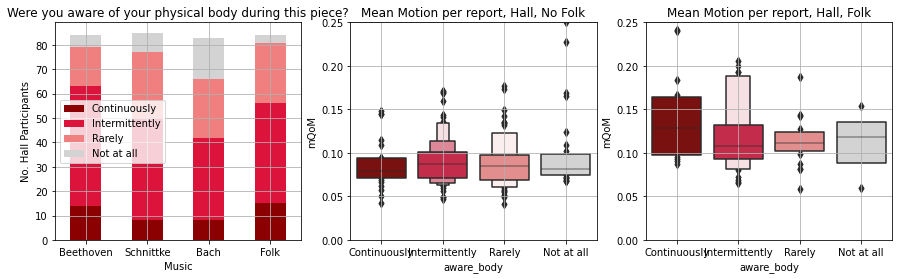

<Figure size 432x288 with 0 Axes>

In [206]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
response_order = ['Continuously','Intermittently','Rarely','Not at all']
my_pal = {'Continuously':'darkred','Intermittently':'crimson','Rarely':'lightcoral','Not at all':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_H[tag_Q + '_' + t].value_counts()

f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,4))

sub_hist_df.plot(kind='bar',stacked=True,color = my_pal.values(),ax = ax1)
ax1.legend(loc="center left")
ax1.grid()
ax1.tick_params(axis='x',labelrotation=0)
ax1.set_title(QuT)
#ax1.set_title('Hall Participants awareness of their own bodies')
ax1.set_ylabel('No. Hall Participants')
ax1.set_xlabel('Music')

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_less)
print(aov)

sns.boxenplot(x = tag_Q,y = tag_m, palette=my_pal,order = response_order,data = mm_df_less, ax = ax2)
ax2.set_title('Mean Motion per report, Hall, No Folk')
ax2.set_ylim([0,0.25])
ax2.grid()

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_Folk)
print(aov)

sns.boxenplot(x = tag_Q,y = tag_m, palette=my_pal,order = response_order,data = mm_df_Folk, ax = ax3)
ax3.set_title('Mean Motion per report, Hall, Folk')
ax3.set_ylim([0,0.25])
ax3.grid()

plt.show()
plt.savefig('./Plots/body_aware_A_R_qom_less.png',dpi = 300)

### Amount of motion (normative)


In [235]:
tag_Q = 'aware_movement'
tag_m = 'mQoM'
QuT = sub_text.loc[tag_Q + '_' + 'Folk','English_Q']
sub_text.loc[sub_text.index.str.startswith(tag_Q),'English_Q']

ID
aware_movement_Beethoven    Were you aware of your own physical movement d...
aware_movement_Schnittke    Were you aware of your own physical movement d...
aware_movement_Bach         Were you aware of your own physical movement d...
aware_movement_Folk         Were you aware of your own physical movement d...
Name: English_Q, dtype: object

In [236]:
print(QuT)
QuT = 'How much did you move relative to your own usual behaviour...' 


Were you aware of your own physical movement during this piece? If so, how much did you move relative to your own usual behaviour at this kind of concert?


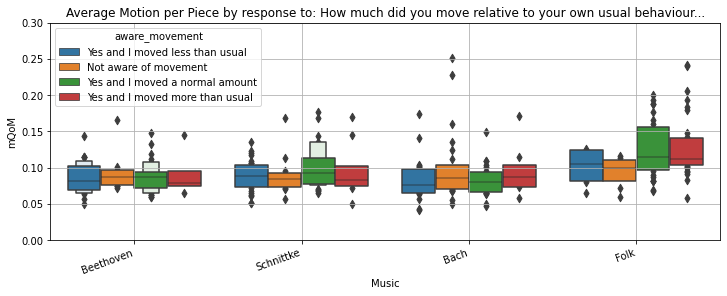

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,aware_movement,0.014250,3,8,0.004750,1.427666,0.304721,0.348693,NaN
1,Music,0.011143,3,24,0.003714,12.716482,0.000036,0.613834,0.430282
2,Interaction,0.007726,9,24,0.000858,2.938827,0.016814,0.524276,NaN


In [237]:
f, (ax1) = plt.subplots(1, 1,figsize=(12,4))
response_order = ['Yes and I moved more than usual','Yes and I moved a normal amount','Yes and I moved less than usual','Not aware of movement']
sns.boxenplot(x = 'Music',y = tag_m, hue = tag_Q,data = mm_df_Hall, ax = ax1)
plt.xticks(rotation='20',ha = 'right',fontsize=10)
plt.title('Average Motion per Piece by response to: ' + QuT)
plt.ylim([0,0.3])
plt.grid()
#plt.savefig('plots/Musics_mQoM_Hall_Virtual.png',dpi = 400)
plt.show()
pg.mixed_anova(dv=tag_m,within = 'Music',between = tag_Q,subject='Participant',data=mm_df_Hall)


           Source  ddof1       ddof2         F     p-unc       np2
0  aware_movement      3  135.377537  5.050367  0.002392  0.046914


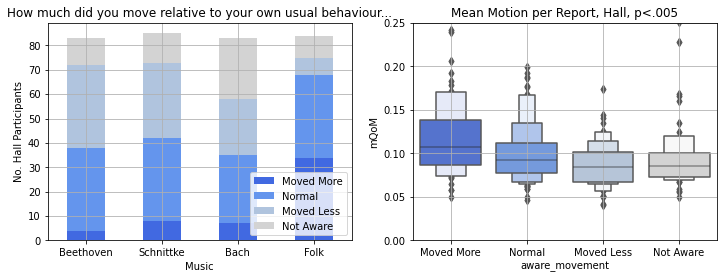

<Figure size 432x288 with 0 Axes>

In [238]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
response_order = ['Yes and I moved more than usual','Yes and I moved a normal amount','Yes and I moved less than usual','Not aware of movement']
short_responses = ['Moved More','Normal','Moved Less','Not Aware']
my_pal = {'Yes and I moved more than usual':'royalblue','Yes and I moved a normal amount':'cornflowerblue','Yes and I moved less than usual':'lightsteelblue','Not aware of movement':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_H[tag_Q + '_' + t].value_counts()
sub_hist_df
sub_hist_df.rename(columns={'Yes and I moved more than usual':'Moved More','Yes and I moved a normal amount':'Normal','Yes and I moved less than usual':'Moved Less','Not aware of movement':'Not Aware'},inplace=True)

f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

sub_hist_df.plot(kind='bar',stacked=True,color = my_pal.values(),ax = ax1)
ax1.legend(loc="best")
ax1.grid()
ax1.tick_params(axis='x',labelrotation=0)
ax1.set_title(QuT)
#ax1.set_title('Hall Participants awareness of their own bodies')
ax1.set_ylabel('No. Hall Participants')
ax1.set_xlabel('Music')

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_Hall)
print(aov)

sns.boxenplot(x = tag_Q,y = tag_m, palette=my_pal,order = response_order,data = mm_df_Hall, ax = ax2)
ax2.set_xticklabels(short_responses)

ax2.set_title('Mean Motion per Report, Hall, p<.005')
ax2.set_ylim([0,0.25])
ax2.grid()

plt.show()
plt.savefig('./Plots/body_move_A_R_qom.png',dpi = 300)

In [239]:
pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Not aware of movement,Yes and I moved a normal amount,0.096058,0.110235,-0.014177,0.007289,-1.944836,182.029814,0.213244,-0.285352
1,Not aware of movement,Yes and I moved less than usual,0.096058,0.101320,-0.005262,0.007430,-0.708234,162.963913,0.887804,-0.110693
2,Not aware of movement,Yes and I moved more than usual,0.096058,0.130386,-0.034328,0.010625,-3.230880,92.843574,0.009109,-0.574886
3,Yes and I moved a normal amount,Yes and I moved less than usual,0.110235,0.101320,0.008914,0.007426,1.200336,251.191678,0.612155,0.149251
4,Yes and I moved a normal amount,Yes and I moved more than usual,0.110235,0.130386,-0.020151,0.010622,-1.897079,97.429614,0.236181,-0.286436
5,Yes and I moved less than usual,Yes and I moved more than usual,0.101320,0.130386,-0.029065,0.010719,-2.711471,98.634978,0.038925,-0.434613


           Source  ddof1      ddof2         F    p-unc       np2
0  aware_movement      3  64.173667  1.014569  0.39214  0.015771
           Source  ddof1     ddof2         F     p-unc       np2
0  aware_movement      3  18.84458  4.694926  0.012989  0.044463


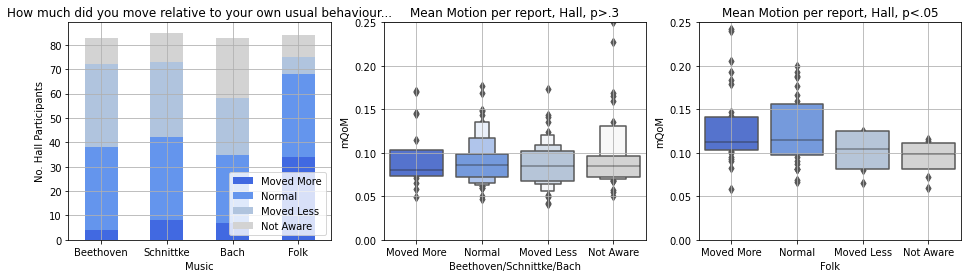

<Figure size 432x288 with 0 Axes>

In [242]:

tracks = ['Beethoven','Schnittke','Bach','Folk']
response_order = ['Yes and I moved more than usual','Yes and I moved a normal amount','Yes and I moved less than usual','Not aware of movement']
short_responses = ['Moved More','Normal','Moved Less','Not Aware']
my_pal = {'Yes and I moved more than usual':'royalblue','Yes and I moved a normal amount':'cornflowerblue','Yes and I moved less than usual':'lightsteelblue','Not aware of movement':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_H[tag_Q + '_' + t].value_counts()
sub_hist_df
sub_hist_df.rename(columns={'Yes and I moved more than usual':'Moved More','Yes and I moved a normal amount':'Normal','Yes and I moved less than usual':'Moved Less','Not aware of movement':'Not Aware'},inplace=True)

f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,4))

sub_hist_df.plot(kind='bar',stacked=True,color = my_pal.values(),ax = ax1)
ax1.legend(loc="best")
ax1.grid()
ax1.tick_params(axis='x',labelrotation=0)
ax1.set_title(QuT)
#ax1.set_title('Hall Participants awareness of their own bodies')
ax1.set_ylabel('No. Hall Participants')
ax1.set_xlabel('Music')

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_less)
print(aov)

sns.boxenplot(x = tag_Q,y = tag_m, palette=my_pal,order = response_order,data = mm_df_less, ax = ax2)
ax2.set_title('Mean Motion per report, Hall, p>.3')
ax2.set_ylim([0,0.25])
ax2.set_xticklabels(short_responses)
ax2.set_xlabel('Beethoven/Schnittke/Bach')
ax2.grid()

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_Folk)
print(aov)

sns.boxenplot(x = tag_Q,y = tag_m, palette=my_pal,order = response_order,data = mm_df_Folk, ax = ax3)
ax3.set_title('Mean Motion per report, Hall, p<.05')
ax3.set_xticklabels(short_responses)
ax3.set_ylim([0,0.25])
ax3.set_xlabel('Folk')
ax3.grid()

plt.show()
plt.savefig('./Plots/body_move_A_R_qom_less.png',dpi = 300)



In [240]:
pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_Folk)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Not aware of movement,Yes and I moved a normal amount,0.094319,0.132413,-0.038094,0.013732,-2.774050,37.761543,0.040855,-1.029501
1,Not aware of movement,Yes and I moved less than usual,0.094319,0.131162,-0.036843,0.037088,-0.993396,5.346478,0.745042,-0.492768
2,Not aware of movement,Yes and I moved more than usual,0.094319,0.129913,-0.035594,0.010406,-3.420590,29.879686,0.009375,-1.269444
3,Yes and I moved a normal amount,Yes and I moved less than usual,0.132413,0.131162,0.001251,0.038373,0.032604,6.119555,0.900000,0.014228
4,Yes and I moved a normal amount,Yes and I moved more than usual,0.132413,0.129913,0.002500,0.014326,0.174496,52.035745,0.900000,0.043766
5,Yes and I moved less than usual,Yes and I moved more than usual,0.131162,0.129913,0.001249,0.037312,0.033468,5.478846,0.900000,0.014605


### Amount of motion (normative) for OTHERS


In [243]:
tag_Q = 'aware_others_moving'
tag_m = 'Motion_seen'
QuT = sub_text.loc[tag_Q + '_' + 'Folk','English_Q']
sub_text.loc[sub_text.index.str.startswith(tag_Q),'English_Q']

ID
aware_others_moving_Beethoven    Were you aware of others in the audience movin...
aware_others_moving_Schnittke    Were you aware of others in the audience movin...
aware_others_moving_Bach         Were you aware of others in the audience movin...
aware_others_moving_Folk         Were you aware of others in the audience movin...
Name: English_Q, dtype: object

In [244]:
print(QuT)
QuT = 'How much were they moving relative to the usual behaviour...' 

Were you aware of others in the audience moving during the piece? If so, how much were they moving relative to the usual behaviour you observe at this kind of concert?


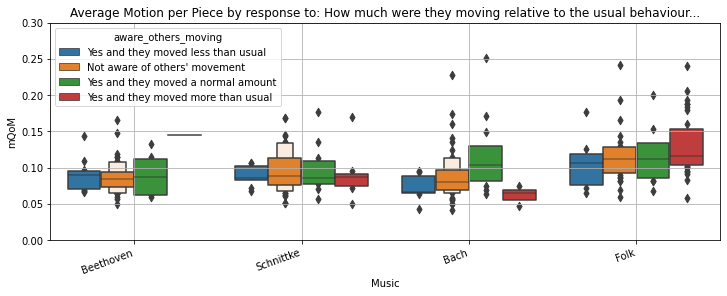

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,aware_others_moving,0.006254,2,21,0.003127,0.495466,0.616233,0.045061,NaN
1,Music,0.034628,3,63,0.011543,8.111834,0.000119,0.278644,0.409077
2,Interaction,0.013924,6,63,0.002321,1.630876,0.153400,0.134440,NaN


In [245]:
f, (ax1) = plt.subplots(1, 1,figsize=(12,4))
sns.boxenplot(x = 'Music',y = 'mQoM', hue = tag_Q,data = mm_df_Hall, ax = ax1)
plt.xticks(rotation='20',ha = 'right',fontsize=10)
plt.title('Average Motion per Piece by response to: ' + QuT)
plt.ylim([0,0.3])
plt.grid()
#plt.savefig('plots/Musics_mQoM_Hall_Virtual.png',dpi = 400)
plt.show()
pg.mixed_anova(dv='mQoM',within = 'Music',between = tag_Q,subject='Participant',data=mm_df_Hall)


In [246]:
sub_H[tag_Q + '_' + t].value_counts()


Yes and they moved more than usual    34
Not aware of others' movement         27
Yes and they moved a normal amount    15
Yes and they moved less than usual     7
Name: aware_others_moving_Folk, dtype: int64

                Source  ddof1      ddof2         F     p-unc       np2
0  aware_others_moving      3  87.663219  11.98378  0.000001  0.166302


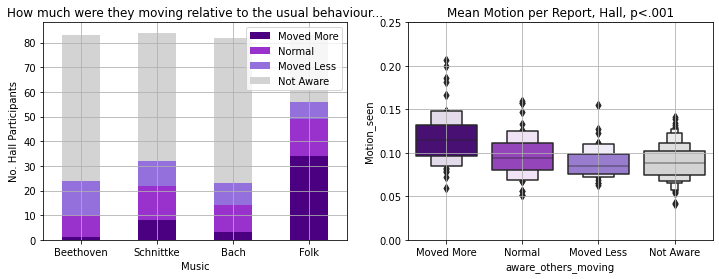

<Figure size 432x288 with 0 Axes>

In [247]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
response_order = ['Yes and they moved more than usual','Yes and they moved a normal amount','Yes and they moved less than usual',"Not aware of others' movement"]
my_pal = {'Yes and they moved more than usual':'indigo','Yes and they moved a normal amount':'darkorchid','Yes and they moved less than usual':'mediumpurple',"Not aware of others' movement":'lightgrey'}
short_responses = ['Moved More','Normal','Moved Less','Not Aware']

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_H[tag_Q + '_' + t].value_counts()
sub_hist_df
sub_hist_df.rename(columns={'Yes and they moved more than usual':'Moved More','Yes and they moved a normal amount':'Normal','Yes and they moved less than usual':'Moved Less',"Not aware of others' movement":'Not Aware'},inplace=True)

f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

sub_hist_df.plot(kind='bar',stacked=True,color = my_pal.values(),ax = ax1)
ax1.legend(loc="best")
ax1.grid()
ax1.tick_params(axis='x',labelrotation=0)
ax1.set_title(QuT)
#ax1.set_title('Hall Participants awareness of their own bodies')
ax1.set_ylabel('No. Hall Participants')
ax1.set_xlabel('Music')

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_Hall)
print(aov)

sns.boxenplot(x = tag_Q,y = tag_m, palette=my_pal,order = response_order,data = mm_df_Hall, ax = ax2)
ax2.set_xticklabels(short_responses)

ax2.set_title('Mean Motion per Report, Hall, p<.001')
ax2.set_ylim([0,0.25])
ax2.grid()

plt.show()
plt.savefig('./Plots/others_move_A_R_qom.png',dpi = 300)

In [248]:
pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_Hall)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Not aware of others' movement,Yes and they moved a normal amount,0.089679,0.098076,-0.008396,0.004175,-2.011288,58.127771,0.195715,-0.327464
1,Not aware of others' movement,Yes and they moved less than usual,0.089679,0.089839,-0.000160,0.003295,-0.048465,57.423472,0.900000,-0.008422
2,Not aware of others' movement,Yes and they moved more than usual,0.089679,0.118575,-0.028896,0.004984,-5.797204,51.746986,0.001000,-0.960413
3,Yes and they moved a normal amount,Yes and they moved less than usual,0.098076,0.089839,0.008237,0.004937,1.668319,82.104007,0.347353,0.355713
4,Yes and they moved a normal amount,Yes and they moved more than usual,0.098076,0.118575,-0.020500,0.006194,-3.309772,86.000857,0.007333,-0.684530
5,Yes and they moved less than usual,Yes and they moved more than usual,0.089839,0.118575,-0.028736,0.005638,-5.096470,72.507308,0.001000,-1.097460


                Source  ddof1      ddof2         F     p-unc       np2
0  aware_others_moving      3  38.175588  1.744884  0.174126  0.024699
                Source  ddof1      ddof2         F     p-unc       np2
0  aware_others_moving      3  23.367486  2.372576  0.096148  0.078062


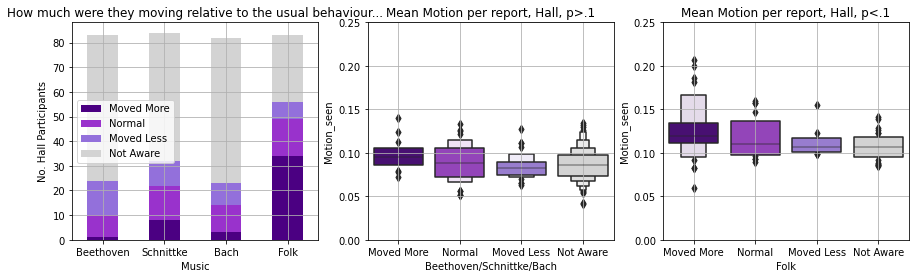

<Figure size 432x288 with 0 Axes>

In [249]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
response_order = ['Yes and they moved more than usual','Yes and they moved a normal amount','Yes and they moved less than usual',"Not aware of others' movement"]
my_pal = {'Yes and they moved more than usual':'indigo','Yes and they moved a normal amount':'darkorchid','Yes and they moved less than usual':'mediumpurple',"Not aware of others' movement":'lightgrey'}
short_responses = ['Moved More','Normal','Moved Less','Not Aware']

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_H[tag_Q + '_' + t].value_counts()
sub_hist_df
sub_hist_df.rename(columns={'Yes and they moved more than usual':'Moved More','Yes and they moved a normal amount':'Normal','Yes and they moved less than usual':'Moved Less',"Not aware of others' movement":'Not Aware'},inplace=True)

f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,4))

sub_hist_df.plot(kind='bar',stacked=True,color = my_pal.values(),ax = ax1)
ax1.legend(loc="center left")
ax1.grid()
ax1.tick_params(axis='x',labelrotation=0)
ax1.set_title(QuT)
#ax1.set_title('Hall Participants awareness of their own bodies')
ax1.set_ylabel('No. Hall Participants')
ax1.set_xlabel('Music')

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_less)
print(aov)

sns.boxenplot(x = tag_Q,y = tag_m, palette=my_pal,order = response_order,data = mm_df_less, ax = ax2)
ax2.set_title('Mean Motion per report, Hall, p>.1')
ax2.set_ylim([0,0.25])
ax2.set_xticklabels(short_responses)
ax2.set_xlabel('Beethoven/Schnittke/Bach')
ax2.grid()

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_Folk)
print(aov)

sns.boxenplot(x = tag_Q,y = tag_m, palette=my_pal,order = response_order,data = mm_df_Folk, ax = ax3)
ax3.set_title('Mean Motion per report, Hall, p<.1')
ax3.set_xticklabels(short_responses)
ax3.set_ylim([0,0.25])
ax3.set_xlabel('Folk')
ax3.grid()

plt.show()
plt.savefig('./Plots/others_move_A_R_qom_less.png',dpi = 300)



In [250]:
pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_Folk)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Not aware of others' movement,Yes and they moved a normal amount,0.108241,0.118182,-0.009942,0.007389,-1.345423,21.275672,0.541827,-0.430683
1,Not aware of others' movement,Yes and they moved less than usual,0.108241,0.113617,-0.005377,0.008342,-0.644602,8.426992,0.900000,-0.268694
2,Not aware of others' movement,Yes and they moved more than usual,0.108241,0.125721,-0.017481,0.006638,-2.633299,49.716192,0.053067,-0.688819
3,Yes and they moved a normal amount,Yes and they moved less than usual,0.118182,0.113617,0.004565,0.010095,0.452158,14.747268,0.900000,0.199110
4,Yes and they moved a normal amount,Yes and they moved more than usual,0.118182,0.125721,-0.007539,0.008741,-0.862516,34.569653,0.803748,-0.264184
5,Yes and they moved less than usual,Yes and they moved more than usual,0.113617,0.125721,-0.012104,0.009559,-1.266164,13.842819,0.590286,-0.516415
